In [40]:
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from norse.torch.functional.lif import LIFParameters

from cgtasknet.instrumetns.dynamic_generate import SNNStates
from cgtasknet.net.lifrefrac import SNNLifRefrac
from norse.torch.functional.lif_refrac import LIFRefracParameters

from cgtasknet.net.states import LIFRefracInitState
from cgtasknet.tasks.reduce import DefaultParams, DMTask

In [2]:
feature_size = 2
output_size = 3
hidden_size = 400
batch_size = 1
neuron_parameters = LIFRefracParameters(
    LIFParameters(
        alpha=torch.as_tensor(100), method="super", v_th=torch.as_tensor(0.65)
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
)
if True:
    model.load_state_dict(
        torch.load("../models/only_dm_lif_refrac/Only_dm_lif_refrac_net")
    )

In [3]:
states_generator = SNNStates(model)
number_of_tasks = 20

In [4]:
dt = 1e-3
subgroup_finder = SubgroupFinder(dt)
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in range(number_of_tasks):
    dmparams1 = DefaultParams("DMTask").generate_params()
    dmparams1["value"] = np.random.uniform(0, 0.5)
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out, states = states_generator.states(inputs, first_state)
    s = []
    for j in range(len(states)):
        s.append(states[j].lif.z)
    s = torch.stack(s).detach()
    s = s.reshape((s.shape[0], s.shape[2]))
    subgroup_finder.compute_average_freq([s], [inputs[:, 0, 0]], [out], [t_outputs])

In [5]:
dt = 1e-3
subgroup_finder2 = SubgroupFinder(dt)
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.random_state()

for i in range(number_of_tasks):
    dmparams1 = DefaultParams("DMTask").generate_params()
    dmparams1["value"] = np.random.uniform(0.51, 1)
    task = DMTask(dmparams1, mode="value")
    inputs, t_outputs = task.dataset(1)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    out, states = states_generator.states(inputs, first_state)
    s = []
    for j in range(len(states)):
        s.append(states[j].lif.z)
    s = torch.stack(s).detach()
    s = s.reshape((s.shape[0], s.shape[2]))
    subgroup_finder2.compute_average_freq([s], [inputs[:, 0, 0]], [out], [t_outputs])

In [6]:
for name, params in model.named_parameters():
    if name == "exp_f.linear.weight":
        out_weights = torch.clone(params.detach())

In [33]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
strenght_first = answer_first * out_weights[1, :]
strenght_second = answer_second * out_weights[2, :]
strenght_first_freq_second_out = answer_first * out_weights[2, :]
strenght_second_freq_first_out = answer_second * out_weights[1, :]

strenght_first_freq_fixation = fixation_first * out_weights[1, :]
strenght_second_freq_fixation = fixation_second * out_weights[2, :]
strenght_first_freq_second_out_fixation = fixation_first * out_weights[2, :]
strenght_second_freq_first_out_fixation = fixation_second * out_weights[1, :]

strenght_first_sort = sort_elemnts_by_another(strenght_first, strenght_first)
strenght_second_sort = sort_elemnts_by_another(strenght_first, strenght_second)
strenght_first_freq_second_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out
)
strenght_second_freq_first_out_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out
)

strenght_first_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_fixation
)
strenght_second_freq_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_fixation
)
strenght_first_freq_second_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_first_freq_second_out_fixation
)
strenght_second_freq_first_out_fixation_sort = sort_elemnts_by_another(
    strenght_first, strenght_second_freq_first_out_fixation
)

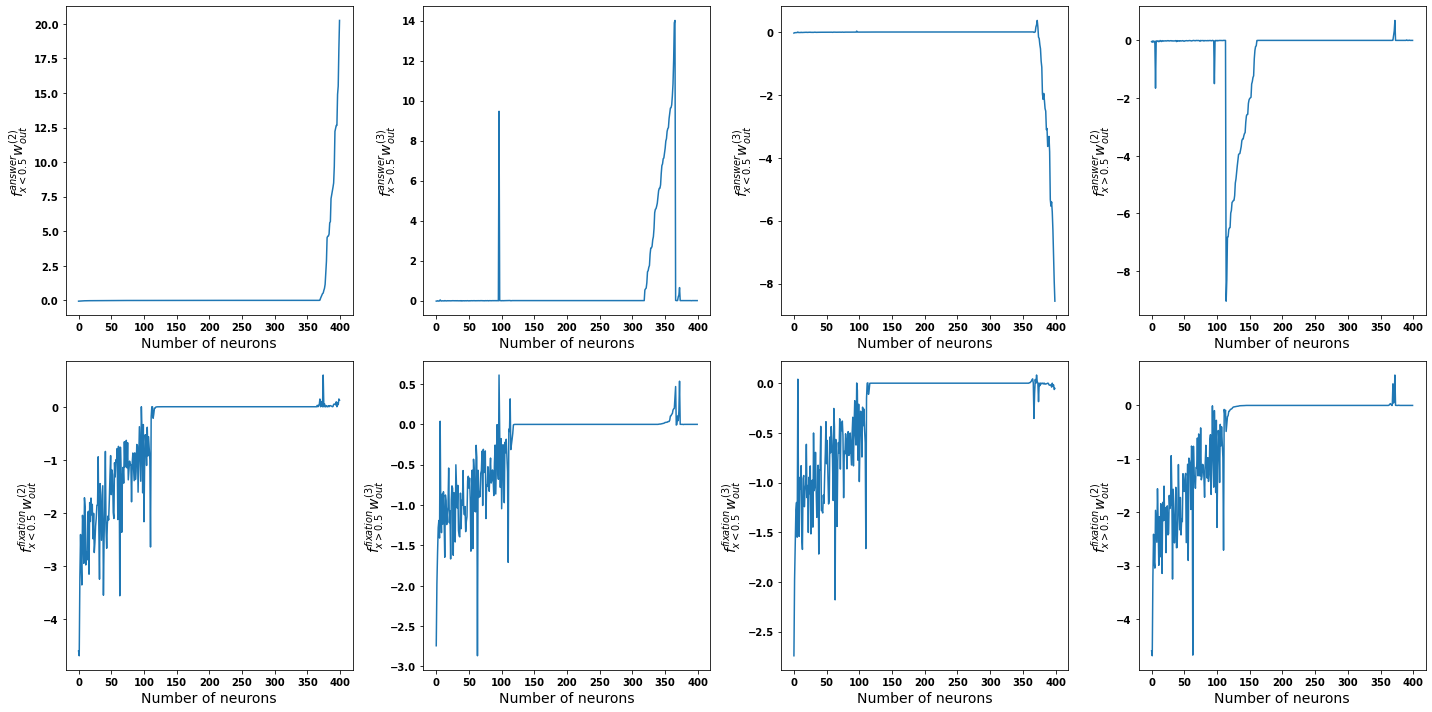

In [53]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))
plt.subplot(241)
plt.plot(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plt.plot(strenght_second_sort.numpy())

plt.subplot(243)
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plt.plot(strenght_first_freq_second_out_sort.numpy())

plt.subplot(244)
plt.ylabel(r"$f^{answer}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.plot(strenght_second_freq_first_out_sort.numpy())

plt.subplot(245)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.plot(strenght_first_freq_fixation_sort.numpy())

plt.subplot(246)
plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plt.plot(strenght_second_freq_fixation_sort.numpy())


plt.subplot(247)
plt.ylabel(r"$f^{fixation}_{x < 0.5} w_{out}^{(3)}$")
plt.xlabel("Number of neurons")
plt.plot(strenght_first_freq_second_out_fixation_sort.numpy())

plt.subplot(248)

plt.ylabel(r"$f^{fixation}_{x > 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.plot(strenght_second_freq_first_out_fixation_sort.numpy())
plt.tight_layout()
plt.savefig("freq_strenght.pdf")
plt.show()

In [57]:
from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

fixation_first, answer_first = subgroup_finder.get_average_freq()
fixation_second, answer_second = subgroup_finder2.get_average_freq()
strenght_first = answer_first * out_weights[1, :]
fixation_first_sort = sort_elemnts_by_another(strenght_first, fixation_first)
fixation_second_sort = sort_elemnts_by_another(strenght_first, fixation_second)
answer_first_sort = sort_elemnts_by_another(strenght_first, answer_first)
answer_second_sort = sort_elemnts_by_another(strenght_first, answer_second)
out1_sort = sort_elemnts_by_another(strenght_first, out_weights[0, :])
out2_sort = sort_elemnts_by_another(strenght_first, out_weights[1, :])
out3_sort = sort_elemnts_by_another(strenght_first, out_weights[2, :])

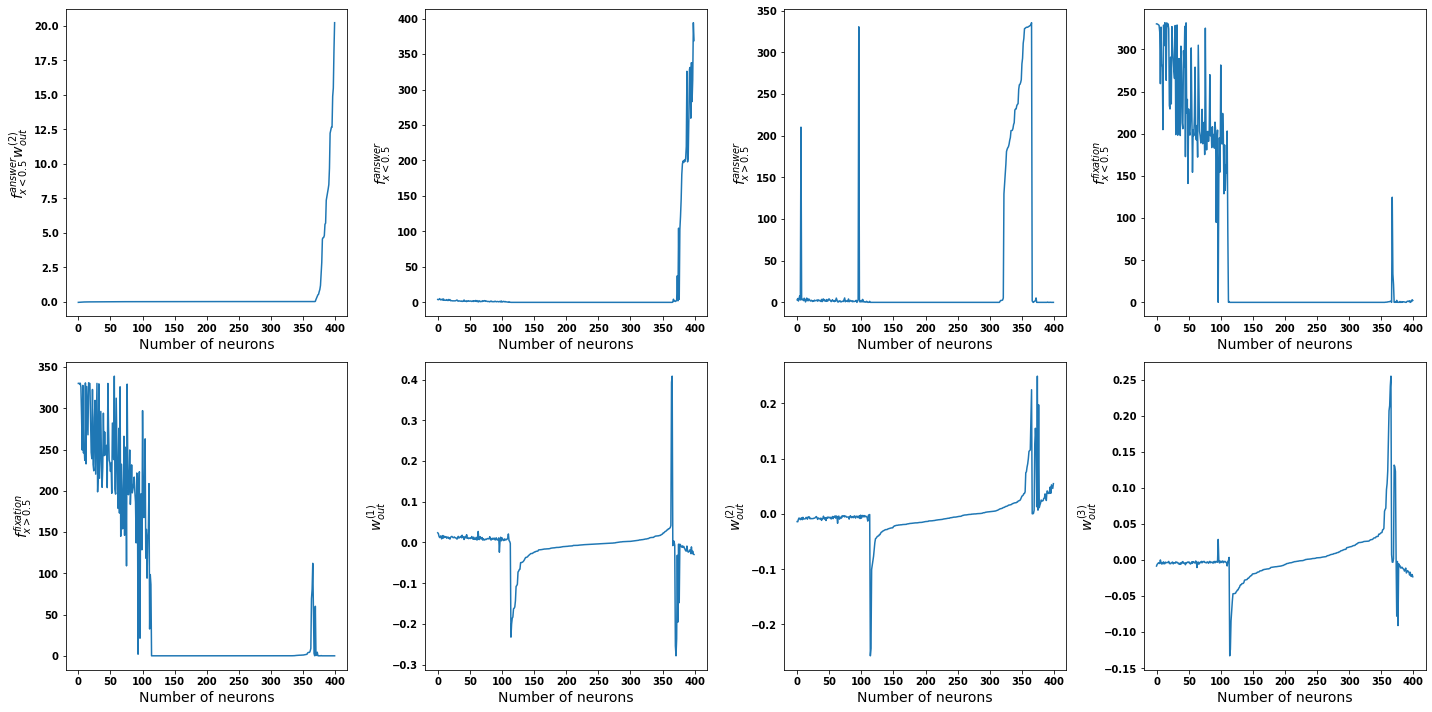

In [59]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.figure(figsize=(20, 10))


plt.subplot(241)
plt.plot(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")

plt.subplot(242)
plt.plot(answer_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(243)
plt.plot(answer_second_sort.numpy())
plt.ylabel(r"$f^{answer}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(244)
plt.plot(fixation_first_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x < 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(245)
plt.plot(fixation_second_sort.numpy())
plt.ylabel(r"$f^{fixation}_{x > 0.5}$")
plt.xlabel("Number of neurons")

plt.subplot(246)
plt.plot(out1_sort.numpy())
plt.ylabel(r"${w_{out}^{(1)}}$")
plt.xlabel("Number of neurons")

plt.subplot(247)
plt.plot(out2_sort.numpy())
plt.ylabel(r"${w_{out}^{(2)}}$")
plt.xlabel("Number of neurons")


plt.subplot(248)
plt.plot(out3_sort.numpy())
plt.ylabel(r"${w_{out}^{(3)}}$")
plt.xlabel("Number of neurons")


plt.tight_layout()
plt.savefig("freq.pdf")
plt.show()

In [93]:
for name, params in model.named_parameters():
    if name == "lif_refrac.recurrent_weights":
        rec_weights = torch.clone(params.detach())

list_numbers = [i for i in range(len(rec_weights))]

In [109]:
for name, params in model.named_parameters():
    if name == "lif_refrac.input_weights":
        input_weights = torch.clone(params.detach())

In [110]:
input_weights.shape

torch.Size([400, 2])

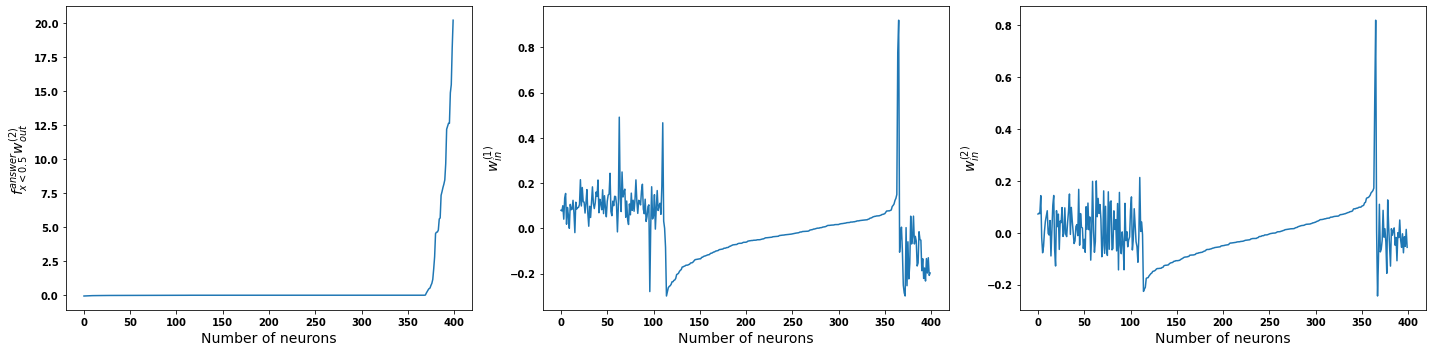

In [124]:
input_sort_1 = sort_elemnts_by_another(strenght_first, input_weights[:, 0])
input_sort_2 = sort_elemnts_by_another(strenght_first, input_weights[:, 1])

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(strenght_first_sort.numpy())
plt.ylabel(r"$f^{answer}_{x < 0.5} w_{out}^{(2)}$")
plt.xlabel("Number of neurons")
plt.subplot(132)
plt.plot(input_sort_1.numpy())
plt.ylabel(r"$w_{in}^{(1)}$")
plt.xlabel("Number of neurons")
plt.subplot(133)
plt.plot(input_sort_2.numpy())
plt.ylabel(r"$w_{in}^{(2)}$")
plt.xlabel("Number of neurons")
plt.tight_layout()
plt.savefig("w_in.pdf")
plt.show()

In [94]:
list_numbers_sort = sort_elemnts_by_another(strenght_first, list_numbers)

In [95]:
for i in range(len(list_numbers)):

    tmp = torch.clone(rec_weights[list_numbers_sort[i]])
    rec_weights[list_numbers[i]] = rec_weights[list_numbers_sort[i]]
    rec_weights[list_numbers_sort[i]] = tmp
    # rec_weights[list_numbers[i], :], rec_weights[list_numbers_sort[i], :] = (
    #     rec_weights[list_numbers_sort[i], :],
    #     rec_weights[list_numbers[i], :],
    # )

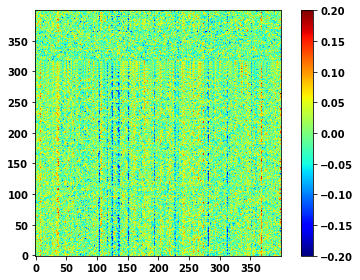

In [126]:
plt.imshow(rec_weights.numpy(), origin="lower", vmin=-0.2, vmax=0.2, cmap="jet")
plt.colorbar()
plt.tight_layout()
plt.savefig("rec_w.pdf")